MSC 11-2022

# Spectral Analysis

- [**Imports**](#Imports)
- [**Introduction**](#Introduction)
- [**Mathematics**](#Mathematics)
    - [**Random Processes**](#Random-Processes)
    - [**Mean & Correlation Functions**](#Mean-&-Correlation-Functions)
    - [**Stationary Random Processes**](#Stationary-Random-Processes)
    - [**Power Spectral Density**](#Power-Spectral-Density)
- [**PSDs in Openseize**](#PSDs-in-Openseize)
- [<b><font color='seagreen'>A Cautionary Example</b></font>](#A-Cautionary-Example)
- [**STFT & Spectrograms**](#STFT-&-Spectrograms)
- [**References**](#References)

## Imports

In [1]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from openseize import producer
from openseize.io.edf import Reader
from openseize import demos
from openseize.spectra import estimators

## Introduction

In the Fourier Transform demo, we explored how the Discrete Fourier Transform (DFT) takes a sequence from the time domain space and maps it to a new sequence in the frequency domain space. This method of spectral analysis is fine for deterministic signals like sines and cosines but is not appropriate for random signals. The DFT of a random signal is itself random. This means that the DFT will vary from one experiment to the next.
<br>
&emsp; This tutorial will present two methods for exploring the spectral content of discrete random signals. To determine which method to use, the researcher will need to answer this key question; <b><i>Is the random signal whose frequency content I wish to know stationary?</i></b>. To understand why this question is important, we'll start this demo by defining a random process and work our way towards stationarity. It is strongly encouraged that all readers who wish to perform spectral analysis carefully consider the following mathematics discussion.

## Mathematics

### Random Processes

A discrete-time random process is a collection of random variables $X_1, X_2, X_3, ...$ that are usually indexed by time. Formally a random process is written as:
<br>
<br>
<p style="text-align: center;">
    $
    \{X[n], \ n \in \mathbb{Z}\} \quad (1)
    $ 
</p>
<br>
<br>

#### Lets plot a simple random process $\{X[n], \ n=0, 1, 2, ...\}$ and each X[n] is ~ Normal(0,1).

In [2]:
def gaussian_rp(size, seed=None):
    """Returns a random process with size elements using a random seed."""
    
    rng = np.random.default_rng(seed)
    return rng.normal(0,1, size=size)

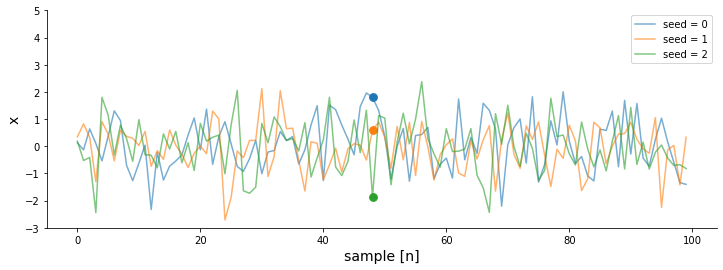

In [3]:
# create three 100 element "realizations" of our random process using different 
# random seeds
seeds = np.arange(3)
x = [gaussian_rp(100, s) for s in seeds]

# plot each realization 
fig, ax = plt.subplots(figsize=(12, 4))
for signal, seed in zip(x, seeds):
    ax.plot(signal, label='seed = {}'.format(seed), alpha=0.6)

#configure the plot
ax.set_xlabel('sample [n]', fontsize=14)
ax.set_ylabel('x', fontsize=14)
ax.set_ylim([-3, 5])
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc='upper right')

# plot the 48th element for each realization
ax.scatter(48, x[0][48], s=60)
ax.scatter(48, x[1][48], s=60)
ax.scatter(48, x[2][48], s=60)

plt.show()

For each random seed we get a unique path called the <b>sample path or realization of the random process</b>. Each point in each path is a random variable. We have plotted the 48th sample random variable $X[n=48] = x_{48}$ for each realization as a colored dot. It is important to note that each sample path drew random variables from the same probability distrubution -- the Normal(0,1) distribution. This is not required, <b>the random process that generates each random variable in a sample path or realization does not need to come from the same distribution.</b> We are getting close to defining stationarity but before we do that, lets examine properties of these sample paths. In particular we will define a sample paths expected value function and correlation function.

### Mean & Correlation Functions

The mean of a random process is defined as:
<br>
<br>
<p style="text-align: center;">
    $
    \mu_X[n] = E\{X[n]\} \quad (2)
    $ 
</p>
<br>
<br>

Be careful, this is not the mean value of a sample path. That would be just a constant number. No this is a mean function. At each index n we compute the expected value of X[n]. In our case above, the expected value is E[Normal(0,1)] which is 0. So $\mu_X[n] = 0$ at each n. Another way to think about this is to generate many many sample paths and at each index average the random variables of each sample path at that index. This is the mean function. Formally, we define it as:
<br>
<br>
<p style="text-align: center;">
    $
    \mu_X[n] = E\{X[n]\} = \sum \limits_{n=-\infty}^\infty P(X[n]) X[n] \quad (3)
    $ 
</p>
<br>
<br>

Technical note, we have the sum from $-\infty$ to $\infty$. Thats no problem for EEGs where the samples run from 0 to some finite number N because we just set the probability $P(X[n])$ to be 0 everywhere except $n \in [0, N]$. 

The mean function gives us the expected value of X[n] at sample n but it does not tell us how the samples in a sample path are related. That is, given index p and index q in a sample path is their a relationship between X[p] and X[q]? The autocorrelation function tells us how samples in a sample path are related. The autocorrelation, or simply correlation function, is defined as:
<br>
<br>
<p style="text-align: center;">
    $
    R_X(p, q) = E\{X[p]X[q]\} \quad \textrm{for} \quad p,q \in [0, N] \quad (4)
    $ 
</p>
<br>
<br>
And the autocovariance, more simply called the covariance, is defined as:
<p style="text-align: center;">
    $
    C_X(p, q) = E\Bigl\{(X[p]-E\{X[p]\}) \ (X[q]-E\{X[p]\})\Bigr\} \quad \textrm{for} \quad p,q \in [0, N] \quad (5)
    $ 

Interpreting $C_X$, when X[p] and X[q] are both large compared to their means, $C_X$ will be positive. Conversely, when both are large but negative, $C_X$ is again positive. If X[p] is near its mean then no matter what X[q] is the covariance will be small. <b>In summary, the covariance tracks how X[p] and X[q] move together.</b>  

### Stationary Random Processes

In our random process example, we knew that each random variable along a a single sample path came from the same normal distribution. Mathematicians refer to this as <b>Strict-Sense Stationary</b>. In terms of the joint probability distribution function P, of two sample indices p and q, we can write this as: 
<br>
<br>
<p style="text-align: center;">
    $
    P(X[p], X[q]) = P(X[p+\Delta], X[q+\Delta]) \quad \textrm{for all} \quad p, q, \Delta \in [0,N] \quad (6)
    $ 
</p>
<br>
<br>

In words, <i>a time shift of two points in a random process does not change the processes joint statistical properties</i>. The joint PDF is the same under translation. This property defines Strict Sense Stationary. For EEG data, we do not know if such a distribution exist nor if this distribution changes across the sample indices. However, there is a weaker form of stationarity called <b>Weak or Wide-Sense Stationary</b>. This will give us a practical definition of stationarity without requiring us to know the PDF.

A random process is called Wide-Sense stationary if its mean function $\mu_x[n]$ and its correlation function $R_X(p, q)$ do not change when the samples are shifted in time. These properties can be written as:
<br>
<br>
<p style="text-align: center;">
    $
    E\{X[p]\} = E\{X[q]\}
    $ 
</p>
<p style="text-align: center;">
    $
    R_X(p, q) = E\{X[p]X[q]\} = E\{X[p+\Delta]X[q+\Delta]\}
    $
</p>


This definition can be simplified a little more. Since the mean function does not depend on time, $\mu_X[n] = \mu_X \textrm{for all} \ n$. Second, the correlation function does not depend on p and q individually, it depends on the difference between p and q. So we can write $R_X(p, q) = R_X(p-q)$. This means if we are at sample p, the correlation function depends only on the distance in samples ($\tau$) away from p. Therefore $R_X(p, q) = E\{X[p]X[p+\tau]\} = R_X(\tau)$.

<b> An EEG random process is Wide-Sense Stationary (WSS) if:</b>
<p style="text-align: center;">
    $
    \mu_X[n] = \mu_x  \quad \textrm{ for all} \ n \in \mathbb{Z}  \quad (7) 
    $
</p>

<p style="text-align: center;">
    $
    R_X[p, q] = R_X(p-q) = E\{X[p]X[p+\tau]\} = R_X(\tau) \quad \textrm{for all} \ p,q, \tau \in \mathbb{Z} \
    \quad (8)
    $
</p>

Lets pause here to absorb what we've just learned. For a WSS random process, the mean does not change in time. Second, we can pick any sample from the signal and the correlation function measured from that sample will depend only on how far we are from that sample and not on the sample we picked. To explore a little further, consider the Normal(0,1) random processes we defined above.

</br>
</br>
<p style="text-align: center;">
    $
    \begin{align*}
        R(\tau) = \begin{cases}
                    E\{X^2[p]\} = 1 & \tau=0\\
                    E\{X[p]X[p+\tau]\} = E\{X[p]\}E\{X[p+\tau]\} = 0 & \tau \neq 0
                \end{cases} \quad (9)
    \end{align*}        
    $
</p>

Lets plot the correlation function for each of the three sample paths of our Normal(0,1) example to see if Eqn. 9 holds.

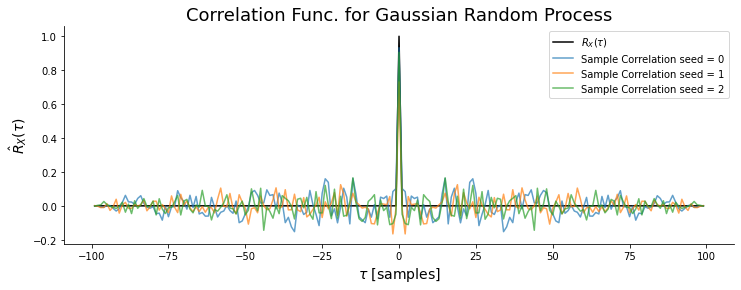

In [4]:
# create  the same 3 sample paths of our N(0,1) gaussian process again
seeds = np.arange(3)
x = [gaussian_rp(100, s) for s in seeds]

# compute the correlation function of each sample path and the length
correlations = [np.correlate(s, s, mode='full')/len(s) for s in x]
corr_len = len(correlations[0])

# plot the correlation functions 
fig, ax = plt.subplots(figsize=(12,4))

# these are the centered taus since tau can be + or -
taus = np.arange(corr_len)-(corr_len)//2

#plot the correlation function of Eqn. 9
actual = np.zeros(len(taus))
actual[len(taus)//2] = 1
ax.plot(taus, actual, color='k', label=r'$R_X(\tau)$')

# plot the sample correlation functions
for corr, seed in zip(correlations, seeds):
    ax.plot(taus, corr, alpha=0.7,label='Sample Correlation seed = {}'.format(seed))
    

ax.set_xlabel(r'$\tau$ [samples]', fontsize=14)
ax.set_ylabel(r'$\hat{R}_X(\tau)$', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_title('Correlation Func. for Gaussian Random Process', fontsize=18)
ax.legend()
plt.show()

Technical note; notice we called the correlation function $\hat{R}_X(\tau)$. Thats because we are approximating the actual correlation function of Eqn. 9. This approximation reflects the fact that the expectation value is only using a 100 element sample and not an infinite number of samples.

For this example, the correlation function is only a function of $\tau$, the difference between any two samples (see Eqn. 9). So this process is wide-sense stationary. <b>How might we tell if an EEG random process is wide-sense stationary? </b>This important question can be answered at several different levels. First there is visual inspection of the sample path. Changes in the mean or variance of a signal, pronounced trends or cycles can be used to reject that a signal is stationary. These are the obvious tests. More statistically satisfying tests are parametric tests such as the Dickey-Fuller test for unit roots and non-parameteric test that examine local Fourier spectra (Basu 2009). The reference section of this demo list a few papers for the interested reader. 

At this point it is natural to ask <b>What does the correlation function and this discussion of stationarity have to do with spectral analysis?</b>. We are at the heart of spectral analysis. Lets keep going.

### Power Spectral Density

#### Weiner-Khintchine-Einstein Theorem

The <b>Power Spectral Density (PSD) of a wide-sense stationary signal is the Fourier transfrom of the correlation function $R_X(\tau)$.</b> This holds for both a continuous (left eqn.) or discrete (right eqn.) random process.
<br>
<br>
<p style="text-align: center;">
    $
    S_X(\omega) = \int \limits_{-\infty}^{\infty}R_X(\tau)e^{-i\omega \tau}d\tau \quad \quad S_X(\omega) = \sum \limits_{\tau=-\infty}^{\infty}R_X[\tau]e^{-i\omega \tau} \quad (10)
    $ 
</p>
<br>
<br>
and the correlation function can be written in terms of the PSD using the inverse transform:
<br>
<br>
<p style="text-align: center;">
    $
    R_X(\tau) = \int \limits_{-\infty}^{\infty}S_X(\omega)e^{i\omega \tau}d\omega \quad \quad  R_X(\tau) = \sum \limits_{\omega=-\infty}^{\infty}S_X(\omega)e^{i\omega \tau} \quad (11)
    $ 
</p>
<br>
<br>

These are big definitions and we need to look at them closely. Consider when $\tau=0$. In this case, 
<br>
<br>
<p style="text-align: center;">
    $
    R_X(0) = E\{X^2(t)\} = \int \limits_{-\infty}^{\infty}S_X(\omega)d\omega \quad \quad R_X(0) = E\{X^2[n]\} = \sum \limits_{\omega=-\infty}^{\infty}S_X(\omega) \quad (12)
    $ 
</p>

In Eqns. 12, $E\{X^2[n]\}$ is the average power of x[n]. Nautrally, this average power in the time domain is equivalent to summing the power spectral density over all frequencies $\omega$. That is why $S_X(\omega)$ is understood to be a density. In fact, there is a theorm called Parseval's theorem that says total power in the time domain exactly equals the total power in the frequency domain.
<br>
&emsp; To get an intuition for Eqns. 10, consider that $R_X$ will have peaks at a non-zero values of $\tau$ if the signal contains periodic components. At these values of $\tau$ the integral in Eqn. 10 adds a small contribution to the PSD by influencing the amplitude of the sines and cosines in the $e^{-i \omega \tau}$ term. The idea that periodicity reflected in the shape of $R_X$ in the time domain contributes to the PSD, a function in the frequency domain, is key to understanding these transforms.

At this point, we have a method for computing the Power Spectral Density, 
1. given a wide-sense stationary signal, we compute its correlation function
2. we transform the correlation function to frequency space using the DFT giving us the PSD.  

However, computing the correlation function is expensive. Each point in the signal is multiplied by all other points in the signal. This is N<sup>2</sup> operations for a signal of length N. A corollary to the WKE theorem above is that <b> the PSD of a wide-sense stationary signal may be estimated from the squared average of the magnitude of the Fourier Transform of the signal x[n]</b>: 

Given a WSS random process signal x[n] and 
</br>
</br>
<p style="text-align: center;">
    $
    E\{|X^F(\omega)|^2\} = S_X(\omega)
    $
</p>
</br>

This forms the basis for Welch's method which takes a signal and breaks it into M chunks of length K each. For each chunk, we compute the DFT and then average the squared magnitude of the DFTs across chunks. One final detail before we turn to applications, each chunk is windowed creating a modified DFT to avoid spurious oscillations (please review the fourier transform demo for details). Since the window will have reduced weight at the edges of each chunk, the chunks are typically overlapped at 50% so that all the data in each chunk recieves equal weight and contribution to the PSD. Lets dig into these details by looking at Openseize power-spectral density function.

## PSDs in Openseize

In [5]:
# lets walk through the call signature of Openseize's PSD
help(estimators.psd)

Help on function psd in module openseize.spectra.estimators:

psd(data, fs, axis=-1, resolution=0.5, window='hann', overlap=0.5, detrend='constant', scaling='density')
    A power spectrum (density) estimator using Welch's method.
    
    Welch's method divides data into overlapping segments and averages the
    modified periodograms for each segment. This estimator can process 
    ndarrays or producer of ndarrays allowing it to estimate the PSD for
    large data sets.
    
    Args:
        data: An ndarray or producer of ndarrays
            A data producer whose power spectral is to be estimated.
        fs: int
            The sampling rate of the data.
        axis: int
            The sample axis of the data. The estimate will be 
            carried out along this axis.
        resolution: float
            The frequency resolution of the estimate in Hz. The resolution
            determines the number of DFT frequencies between [0, fs) to use
            to estimate the powe

In [6]:
fp = demos.paths.locate('recording_001.edf')
reader = Reader(fp)
reader.channels = [0]
fs = 5000
arr = reader.read(0, fs*5)
arr = arr.flatten()

In [7]:
# open demo data
# inspect for a 30 s stationary period
# compute the PSD at different resolutions and plot

# find non-stationary section and plot

# work-out example where bad assumption of stationary creates problems in PSD

# STFT

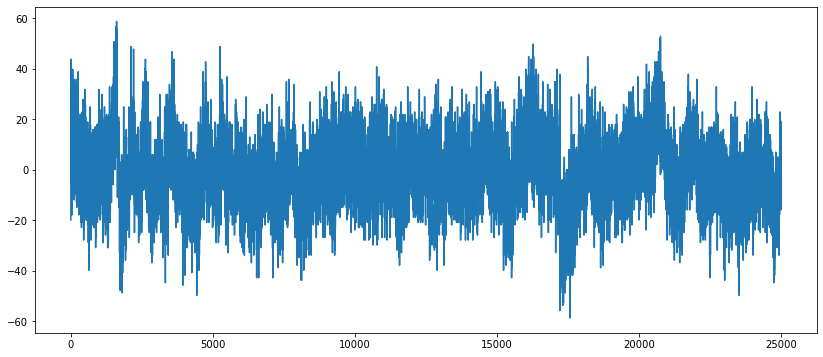

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(arr)

In [9]:
cnt, freqs, res = estimators.psd(arr, fs=fs)

(5001,)
(5001,)
(5001,)
(5001,)
(0,)


ValueError: operands could not be broadcast together with shapes (0,) (5001,) 

In [10]:
arr.shape

(25000,)